In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [2]:
#定义变量 
thermal_power_station_strategy=np.zeros(shape=(4,1000)) 
wind_power_station_strategy=np.zeros(shape=(2,1000))
c_wind_speed= np.loadtxt("./data/c_wind_speed_uniform_distribution_(3,25).txt")      
kappa_wind_speed= np.loadtxt("./data/kappa_wind_speed_uniform_distribution_(2,3).txt")  
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt") #时变的需求侧用电需求  阶梯式变化 
thermal_power_station_dual_variable=np.zeros(shape=(4,1000))
wind_power_station_dual_variable=np.zeros(shape=(2,1000))#两个风力发电站中有一个是受到拜占庭攻击的 假设第二个风力发电站是受到攻击的
E=np.loadtxt("6_Network_Topology_Double_Random_Adjacency_Matrix.txt")
thermal_power_station_cost=np.zeros(shape=(1,1000)) #火力发电成本
wind_power_station_cost=np.zeros(shape=(1,1000)) #风力发电成本
sum_cost=np.zeros(shape=(1,1000)) #总发电成本
#thermal_power_station_eta=[0.0375,0.0375,0.0625,0.035]
thermal_power_station_eta=[0.0675,0.0675,0.0925,0.0625]
thermal_power_station_zeta=[2,1.75,1,3]
thermal_power_station_xi=[0,0,0,0]
thermal_power_station_P_min=[50,20,15,10]
thermal_power_station_P_max=[200,120,80,100]
#wind_power_station_varphi=[3,6]
wind_power_station_varphi=[1,6]
wind_power_station_v_in=[3,5]
wind_power_station_v_out=[25,25]
wind_power_station_v_r=[13,15]
wind_power_station_sigma_ue=[5,5]
wind_power_station_sigma_oe=[30,20]
wind_power_station_P_r=[160,160]
wind_power_station_P_min=[0,0]
wind_power_station_P_max=[160,160]
sum_thermal_wind_power_station_strategy=np.zeros(shape=(1,1000))
step_size_primal=1
step_size_dual=1
regularization_parameter=0.001

In [3]:
#火力，风力发电策略初始化
thermal_power_station_strategy[0][0]=0
thermal_power_station_strategy[1][0]=0
thermal_power_station_strategy[2][0]=0
thermal_power_station_strategy[3][0]=0
wind_power_station_strategy[0][0]=0
wind_power_station_strategy[1][0]=0
#初始总发电策略
sum_thermal_wind_power_station_strategy[0][0]=0
#初始化受到攻击的风力发电站的对偶变量
wind_power_station_dual_variable[1][0]=-300

#安全发电站的初始总发电成本
#火力发电成本
for i in range(0,4):
    thermal_power_station_cost[0][0]=thermal_power_station_cost[0][0]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][0]*thermal_power_station_strategy[i][0]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][0]
#风力发电成本
for i in range(0,1):
    wind_power_station_cost[0][0]=wind_power_station_cost[0][0]+wind_power_station_varphi[i]*wind_power_station_strategy[i][0]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_r[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][0])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_in[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))
#发电总成本
sum_cost[0][0]=thermal_power_station_cost[0][0]+wind_power_station_cost[0][0]


In [4]:
def Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual):
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("***************************attack_free_online_decentralized_economic_dispatch*****************************")
    print("相关变量初始值为：")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始计划发电量为:",thermal_power_station_strategy[i][0])
    for i in range (0,2):
        print("第",(i+5),"个风力发电站的初始计划发电量为:",wind_power_station_strategy[i][0])
    print("****************************************************************************")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[i][0])
    for i in range (0,1):
        print("第",(i+5),"个风力发电站的初始对偶变量为:",wind_power_station_dual_variable[i][0])
    print("****************************************************************************")
    print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][0])
    print("****************************************************************************")
    print("安全发电站的初始总发电量:",sum_thermal_wind_power_station_strategy[0][0])
    print("*************************")
    print("需求侧平均用电需求:",d_power_demand[0])
    print("****************************************************************************")
    print("风速分布参数c:",c_wind_speed[0])
    print("****************************************************************************")
    print("风速分布参数kappa:",kappa_wind_speed[0])
    print("****************************************************************************")
    print("安全发电站的总发电成本：", sum_cost[0][0])
    print("****************************************************************************")
    print("原变量迭代步长为:",step_size_primal)
    print("*****************************************************************************")
    print("对偶变量迭代步长为:",step_size_dual)
    print("*****************************************************************************")
    
    #开始迭代
    for k in range(1,1000):
        #发电站更新计划发电量和对偶变量
        #对偶变量 先做梯度上升 再做聚合
        #安全发电站的梯度上升
        dual_variable_intermediate=[] #存放当前迭代中6个用户对对偶变量做完梯度下降后得到的中间值
        for i in range(0,4):
            dual_variable_intermediate.append(thermal_power_station_dual_variable[i][k-1]+step_size_dual*((1/6)*thermal_power_station_strategy[i][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*thermal_power_station_dual_variable[i][k-1]))
        for j in range(0,1):
            dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1]+step_size_dual*((1/6)*wind_power_station_strategy[j][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*wind_power_station_dual_variable[j][k-1]))
        #受到攻击的风力发电站的对偶值
        dual_variable_intermediate.append(wind_power_station_dual_variable[1][k-1])
        #聚合 安全的火力发电站的对偶更新
        for i in range(0,4):
            weight_aggregation_dual_variable=0
            for j in range(0,4):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i][j]*dual_variable_intermediate[j]               
            for j in range(0,2):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i][j+4]*dual_variable_intermediate[j+4]
            thermal_power_station_dual_variable[i][k]=weight_aggregation_dual_variable
        #聚合 安全的风力发电站的对偶更新
        for i in range(0,1):
            weight_aggregation_dual_variable=0
            for j in range(0,4):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i+4][j]*dual_variable_intermediate[j]               
            for j in range(0,2):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i+4][j+4]*dual_variable_intermediate[j+4]
            wind_power_station_dual_variable[i][k]=weight_aggregation_dual_variable
        #受到Byzantine攻击的风力发电站的对偶更新
        wind_power_station_dual_variable[1][k]=wind_power_station_dual_variable[1][k-1]            
        
        #安全的火力发电站计划发电量
        for i in range(0,4):
            thermal_power_station_strategy[i][k]=thermal_power_station_strategy[i][k-1]-step_size_primal*(2*thermal_power_station_eta[i]*thermal_power_station_strategy[i][k-1]+thermal_power_station_zeta[i]+(1/6)*thermal_power_station_dual_variable[i][k-1]) 
            if thermal_power_station_strategy[i][k]<=thermal_power_station_P_min[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_min[i]
            elif thermal_power_station_strategy[i][k]>=thermal_power_station_P_max[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_max[i]
        #安全的风力发电站计划发电量
        for i in range(0,1):
            wind_power_station_strategy[i][k]=wind_power_station_strategy[i][k-1]-step_size_primal*(wind_power_station_varphi[i]+wind_power_station_sigma_oe[i]+(wind_power_station_sigma_ue[i]+wind_power_station_sigma_oe[i])*math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(-wind_power_station_sigma_ue[i]-wind_power_station_sigma_oe[i])*math.exp(-(math.pow((wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k-1])/wind_power_station_P_r[i]),kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(1/6)*wind_power_station_dual_variable[i][k-1])
            if wind_power_station_strategy[i][k]<=wind_power_station_P_min[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_min[i]
            elif wind_power_station_strategy[i][k]>=wind_power_station_P_max[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_max[i]
        #受到Byzantine攻击的风力发电站的计划发电量
        wind_power_station_strategy[1][k]=wind_power_station_strategy[1][k-1]
        
        #安全发电站的计算总计划发电
        #火力发电量
        for i in range(0,4):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+thermal_power_station_strategy[i][k]
        #风力发电量
        for i in range(0,1):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+wind_power_station_strategy[i][k]
        
        #安全发电站的计算总发电成本
        #火力发电成本
        for i in range(0,4):
            thermal_power_station_cost[0][k]=thermal_power_station_cost[0][k]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][k]*thermal_power_station_strategy[i][k]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][k]
        #风力发电成本
        for i in range(0,1):
            wind_power_station_cost[0][k]=wind_power_station_cost[0][k]+wind_power_station_varphi[i]*wind_power_station_strategy[i][k]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_r[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][k])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_in[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))
        #发电总成本
        sum_cost[0][k]=thermal_power_station_cost[0][k]+wind_power_station_cost[0][k]
        
        #输出第k次迭代中的结果 每间隔10次迭代输出一次结果
        #if (k+1)%10==0:
        print(k,"次迭代中的结果：")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的计划发电量为:",thermal_power_station_strategy[i][k])
        for i in range (0,2):
            print("第",(i+5),"个风力发电站的计划发电量为:",wind_power_station_strategy[i][k])
        print("****************************************************************************")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的对偶变量为:",thermal_power_station_dual_variable[i][k])
        for i in range (0,1):
            print("第",(i+5),"个风力发电站的对偶变量为:",wind_power_station_dual_variable[i][k])
        print("****************************************************************************")
        print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][k])
        print("****************************************************************************")
        print("安全发电站的总发电量:",sum_thermal_wind_power_station_strategy[0][k])
        print("*************************")
        print("需求侧平均用电需求:",d_power_demand[k])
        print("****************************************************************************")
        print("风速分布参数c:",c_wind_speed[k])
        print("****************************************************************************")
        print("风速分布参数kappa:",kappa_wind_speed[k])
        print("****************************************************************************")        
        print("安全发电站的总发电成本：", sum_cost[0][k])
        print("****************************************************************************")
        print("原变量迭代步长为:",step_size_primal)
        print("****************************************************************************")
        print("对偶变量迭代步长为:",step_size_dual)
        print("****************************************************************************")
        
        #step_size_primal=(pow(k+1,0.1))
        #step_size_dual=1/(pow(k+1,0.7))#我们发现在在线算法中 不能使用太小的对偶步长 不然后续算法对在线变化会不敏感 
        
        '''#尝试使用两阶段的步长
        if k<=500:
            step_size_dual=1/(pow(k+1,0.7))
        else:
            step_size_dual=0.1'''

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
    return None  

In [5]:
Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual)

***************************attack_free_online_decentralized_economic_dispatch*****************************
相关变量初始值为：
第 1 个火力发电站的初始计划发电量为: 0.0
第 2 个火力发电站的初始计划发电量为: 0.0
第 3 个火力发电站的初始计划发电量为: 0.0
第 4 个火力发电站的初始计划发电量为: 0.0
第 5 个风力发电站的初始计划发电量为: 0.0
第 6 个风力发电站的初始计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的初始对偶变量为: 0.0
第 2 个火力发电站的初始对偶变量为: 0.0
第 3 个火力发电站的初始对偶变量为: 0.0
第 4 个火力发电站的初始对偶变量为: 0.0
第 5 个风力发电站的初始对偶变量为: 0.0
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的初始总发电量: 0.0
*************************
需求侧平均用电需求: 72.62781256
****************************************************************************
风速分布参数c: 8.301041
****************************************************************************
风速分布参数kappa: 2.66836324
****************************************************************************
安全

33 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 200.0
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -177.5807293490078
第 2 个火力发电站的对偶变量为: -214.00934069356452
第 3 个火力发电站的对偶变量为: -213.45373884294776
第 4 个火力发电站的对偶变量为: -246.62758048010647
第 5 个风力发电站的对偶变量为: -178.04419439184133
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 660.0
*************************
需求侧平均用电需求: 71.90639999
****************************************************************************
风速分布参数c: 19.92973653
****************************************************************************
风速分布参数kappa: 2.02497384
****************************************************************************
安全发电站的总发电成本： 7784.044697103829
*******

对偶变量迭代步长为: 1
****************************************************************************
61 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 199.02677305346478
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -174.50679790601617
第 2 个火力发电站的对偶变量为: -211.7451590487271
第 3 个火力发电站的对偶变量为: -211.18955719811032
第 4 个火力发电站的对偶变量为: -245.00648127145269
第 5 个风力发电站的对偶变量为: -174.97910128237132
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 659.0267730534648
*************************
需求侧平均用电需求: 65.38000903
****************************************************************************
风速分布参数c: 17.84025909
****************************************************************************
风速分布参数kappa: 2.57965073


第 1 个火力发电站的计划发电量为: 197.48376861610677
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -170.8910468830053
第 2 个火力发电站的对偶变量为: -209.01439945842276
第 3 个火力发电站的对偶变量为: -208.45879760780602
第 4 个火力发电站的对偶变量为: -243.0058036851073
第 5 个风力发电站的对偶变量为: -171.32920039594364
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 657.4837686161068
*************************
需求侧平均用电需求: 65.80577777
****************************************************************************
风速分布参数c: 13.40205487
****************************************************************************
风速分布参数kappa: 2.26518049
****************************************************************************
安全发电站的总发电成本： 7414.59188883

安全发电站的总发电成本： 9177.98647995995
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
116 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 195.4170555949683
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 155.0753260968674
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -170.8557107070034
第 2 个火力发电站的对偶变量为: -208.9313297008441
第 3 个火力发电站的对偶变量为: -208.37572785022732
第 4 个火力发电站的对偶变量为: -242.81224062786265
第 5 个风力发电站的对偶变量为: -171.2933213174311
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 650.4923816918357
*************************
需求侧平均用电需求: 68.13

第 4 个火力发电站的对偶变量为: -243.71786961844003
第 5 个风力发电站的对偶变量为: -172.79752021367676
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 655.0201683135515
*************************
需求侧平均用电需求: 67.72837408
****************************************************************************
风速分布参数c: 17.35833245
****************************************************************************
风速分布参数kappa: 2.819518
****************************************************************************
安全发电站的总发电成本： 6866.8469820816445
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
143 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 197.3804305577216
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发

第 3 个火力发电站的对偶变量为: -210.19008403822727
第 4 个火力发电站的对偶变量为: -244.1021391453882
第 5 个风力发电站的对偶变量为: -173.78354428387655
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 659.4331840347056
*************************
需求侧平均用电需求: 78.25832845
****************************************************************************
风速分布参数c: 23.96339247
****************************************************************************
风速分布参数kappa: 2.80743772
****************************************************************************
安全发电站的总发电成本： 7857.632603147267
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
175 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 199.39804073016563


第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 657.524180921083
*************************
需求侧平均用电需求: 64.84090044
****************************************************************************
风速分布参数c: 3.33061256
****************************************************************************
风速分布参数kappa: 2.20138792
****************************************************************************
安全发电站的总发电成本： 10504.868013147207
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
198 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 197.34527929311645
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 157.55975690114857
第 6 个风力发电站的计划发电量为: 0.0
********************************************************

原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
219 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 198.02224408624588
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -169.79754231548543
第 2 个火力发电站的对偶变量为: -208.07874168365325
第 3 个火力发电站的对偶变量为: -207.5231398330365
第 4 个火力发电站的对偶变量为: -242.13173142752964
第 5 个风力发电站的对偶变量为: -170.24144324433502
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 658.0222440862459
*************************
需求侧平均用电需求: 74.35116785
****************************************************************************
风速分布参数c: 24.20509136
***********

****************************************************************************
风速分布参数c: 9.41004409
****************************************************************************
风速分布参数kappa: 2.15958459
****************************************************************************
安全发电站的总发电成本： 8171.409212739648
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
244 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 196.11947025065956
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 158.1979752343049
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -171.1588778436282
第 2 个火力发电站的对偶变量为: -209.14457755815448
第 3 个火力发电站的对偶变量为: -208.5889757075377
第 4 个火力发电站的对偶变量为: -242.92300504506562
第 5 个风力发电站的对偶变量为: -171.626

第 4 个火力发电站的对偶变量为: -242.58266680351795
第 5 个风力发电站的对偶变量为: -170.51826658087913
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 656.996987023202
*************************
需求侧平均用电需求: 73.90205483
****************************************************************************
风速分布参数c: 24.50752709
****************************************************************************
风速分布参数kappa: 2.22960271
****************************************************************************
安全发电站的总发电成本： 8073.967896578584
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
279 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 196.7501070735145
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发

304 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 198.22508294971803
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 157.97042685234538
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -173.70331621538924
第 2 个火力发电站的对偶变量为: -211.13178472425852
第 3 个火力发电站的对偶变量为: -210.57618287364178
第 4 个火力发电站的对偶变量为: -244.56672301029596
第 5 个风力发电站的对偶变量为: -174.14381663341663
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 656.1955098020635
*************************
需求侧平均用电需求: 78.51409446
****************************************************************************
风速分布参数c: 23.45155527
****************************************************************************
风速分布参数kappa: 2.6231406
****************************************************************************

第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -173.6428290473646
第 2 个火力发电站的对偶变量为: -210.9830002496033
第 3 个火力发电站的对偶变量为: -210.42739839898655
第 4 个火力发电站的对偶变量为: -244.27794328774354
第 5 个风力发电站的对偶变量为: -174.0915818996632
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 659.0359521481195
*************************
需求侧平均用电需求: 72.6857033
****************************************************************************
风速分布参数c: 15.76620721
****************************************************************************
风速分布参数kappa: 2.52237436
****************************************************************************
安全发电站的总发电成本： 7119.86124840206
************************************

对偶变量迭代步长为: 1
****************************************************************************
347 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 199.1668054380963
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 158.03891068643742
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -172.84693584855168
第 2 个火力发电站的对偶变量为: -210.4287399439159
第 3 个火力发电站的对偶变量为: -209.87313809329913
第 4 个火力发电站的对偶变量为: -243.95366817692064
第 5 个风力发电站的对偶变量为: -173.3006602482823
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 657.2057161245336
*************************
需求侧平均用电需求: 63.42890911
****************************************************************************
风速分布参数c: 19.69462348
****************************************************************************
风速分布参数kappa:

需求侧平均用电需求: 63.37710621
****************************************************************************
风速分布参数c: 17.95880771
****************************************************************************
风速分布参数kappa: 2.69216133
****************************************************************************
安全发电站的总发电成本： 7021.896493631258
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
373 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 198.03758059491994
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -172.47013234082766
第 2 个火力发电站的对偶变量为: -210.06956959923122
第 3 个火力发电站的对偶变量为: -209.51396774861448
第 4 个火力发电站的对偶变量为: -243.56037111676994
第 5 个风力发电站的对

风速分布参数c: 10.6230677
****************************************************************************
风速分布参数kappa: 2.32265741
****************************************************************************
安全发电站的总发电成本： 7949.803846077046
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
398 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 197.8163226108864
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -173.5442370513343
第 2 个火力发电站的对偶变量为: -211.0901108694595
第 3 个火力发电站的对偶变量为: -210.53450901884275
第 4 个火力发电站的对偶变量为: -244.66847084931538
第 5 个风力发电站的对偶变量为: -173.9820432488869
****************************************************************************
第 

第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -172.1833845237243
第 2 个火力发电站的对偶变量为: -209.96054241699954
第 3 个火力发电站的对偶变量为: -209.40494056638278
第 4 个火力发电站的对偶变量为: -243.6605368663703
第 5 个风力发电站的对偶变量为: -172.6110329367898
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 657.0250569245871
*************************
需求侧平均用电需求: 67.05037643
****************************************************************************
风速分布参数c: 9.37540169
****************************************************************************
风速分布参数kappa: 2.95486478
****************************************************************************
安全发电站的总发电成本： 8213.4289826857
**************************************************************

第 5 个风力发电站的对偶变量为: -172.63027849544008
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 655.8675752694294
*************************
需求侧平均用电需求: 72.3359604
****************************************************************************
风速分布参数c: 13.86305954
****************************************************************************
风速分布参数kappa: 2.9993725
****************************************************************************
安全发电站的总发电成本： 6964.011112613138
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
451 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 196.128145470422
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个

第 2 个火力发电站的对偶变量为: -210.89064561705425
第 3 个火力发电站的对偶变量为: -210.33504376643748
第 4 个火力发电站的对偶变量为: -244.24872807767372
第 5 个风力发电站的对偶变量为: -173.9420001379231
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 657.1860728623323
*************************
需求侧平均用电需求: 64.80952024
****************************************************************************
风速分布参数c: 7.23074937
****************************************************************************
风速分布参数kappa: 2.23238128
****************************************************************************
安全发电站的总发电成本： 9077.936001148115
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
475 次迭代中的结果：
第

原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
501 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 197.33395122887055
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -171.63456247579046
第 2 个火力发电站的对偶变量为: -209.52933668802336
第 3 个火力发电站的对偶变量为: -208.97373483740662
第 4 个火力发电站的对偶变量为: -243.31194254723857
第 5 个风力发电站的对偶变量为: -172.0667945392975
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 657.3339512288705
*************************
需求侧平均用电需求: 75.978379
****************************************************************************
风速分布参数c: 15.172168
***************

第 2 个火力发电站的对偶变量为: -208.62572245472242
第 3 个火力发电站的对偶变量为: -208.07012060410568
第 4 个火力发电站的对偶变量为: -242.57217530317496
第 5 个风力发电站的对偶变量为: -170.9144882711542
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 656.3139238485335
*************************
需求侧平均用电需求: 79.03465489
****************************************************************************
风速分布参数c: 17.20651434
****************************************************************************
风速分布参数kappa: 2.40837363
****************************************************************************
安全发电站的总发电成本： 7145.434629205114
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
529 次迭代中的结果：


第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -172.41000488706686
第 2 个火力发电站的对偶变量为: -210.04106214281083
第 3 个火力发电站的对偶变量为: -209.48546029219406
第 4 个火力发电站的对偶变量为: -243.55932897908116
第 5 个风力发电站的对偶变量为: -172.83572423447453
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 655.7054061491388
*************************
需求侧平均用电需求: 70.33874121
****************************************************************************
风速分布参数c: 13.99606624
****************************************************************************
风速分布参数kappa: 2.95718113
****************************************************************************
安全发电站的总发电成本： 6953.64435012363
****************************************************************************
原变量迭代步长为: 1
******************************************

第 3 个火力发电站的对偶变量为: -211.56691931620998
第 4 个火力发电站的对偶变量为: -245.43184393712994
第 5 个风力发电站的对偶变量为: -175.37539467597725
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 659.8495822986333
*************************
需求侧平均用电需求: 77.11440689
****************************************************************************
风速分布参数c: 12.35048426
****************************************************************************
风速分布参数kappa: 2.89041079
****************************************************************************
安全发电站的总发电成本： 7408.295359887168
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
583 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 200.0
第 2 个火力发电站的计

****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 656.8322206792202
*************************
需求侧平均用电需求: 71.22768316
****************************************************************************
风速分布参数c: 21.52921835
****************************************************************************
风速分布参数kappa: 2.24503771
****************************************************************************
安全发电站的总发电成本： 7708.157447170452
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
607 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 197.94004427757045
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发

第 2 个火力发电站的对偶变量为: -211.16484834709465
第 3 个火力发电站的对偶变量为: -210.6092464964779
第 4 个火力发电站的对偶变量为: -244.5768078251307
第 5 个风力发电站的对偶变量为: -174.22367388311443
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 659.9284701458096
*************************
需求侧平均用电需求: 73.43487714
****************************************************************************
风速分布参数c: 15.90729999
****************************************************************************
风速分布参数kappa: 2.1973318
****************************************************************************
安全发电站的总发电成本： 7394.400419366257
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
637 次迭代中的结果：
第 

第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -175.54818726345252
第 2 个火力发电站的对偶变量为: -212.48475703282463
第 3 个火力发电站的对偶变量为: -211.9291551822079
第 4 个火力发电站的对偶变量为: -245.50635890548273
第 5 个风力发电站的对偶变量为: -176.0020878543392
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 659.5983771140072
*************************
需求侧平均用电需求: 65.40691617
****************************************************************************
风速分布参数c: 21.3090511
****************************************************************************
风速分布参数kappa: 2.34688882
****************************************************************************
安全发电站的总发电成本： 7678.02419577841
****************************************************************************
原变量迭代步长

第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -172.059112146031
第 2 个火力发电站的对偶变量为: -209.9184748097446
第 3 个火力发电站的对偶变量为: -209.36287295912783
第 4 个火力发电站的对偶变量为: -243.70776893269516
第 5 个风力发电站的对偶变量为: -172.50853237610008
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 658.6677805021702
*************************
需求侧平均用电需求: 72.2446366
****************************************************************************
风速分布参数c: 14.11699691
****************************************************************************
风速分布参数kappa: 2.15613383
****************************************************************************
安全发电站的总发电成本： 7453.713011846219
************************************************************

风速分布参数c: 9.26686397
****************************************************************************
风速分布参数kappa: 2.39883923
****************************************************************************
安全发电站的总发电成本： 8396.393860941205
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
710 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 200.0
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -176.33696679075888
第 2 个火力发电站的对偶变量为: -213.07750241104094
第 3 个火力发电站的对偶变量为: -212.52190056042417
第 4 个火力发电站的对偶变量为: -245.93766731324274
第 5 个风力发电站的对偶变量为: -176.79424433413834
****************************************************************************
第 6 个受到Byza

安全发电站的总发电成本： 8073.735056361378
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
730 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 197.98908823496436
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -171.7275819515086
第 2 个火力发电站的对偶变量为: -209.55537773113804
第 3 个火力发电站的对偶变量为: -208.9997758805213
第 4 个火力发电站的对偶变量为: -243.22230699085657
第 5 个风力发电站的对偶变量为: -172.1911339970037
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 657.9890882349644
*************************
需求侧平均用电需求: 69.07906008
***

****************************************************************************
安全发电站的总发电成本： 9470.455546834617
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
751 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 195.87636861081927
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 157.3728849426142
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -169.67001259717392
第 2 个火力发电站的对偶变量为: -208.075707657103
第 3 个火力发电站的对偶变量为: -207.52010580648627
第 4 个火力发电站的对偶变量为: -242.2800923557192
第 5 个风力发电站的对偶变量为: -170.08740055472632
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
**********************************************************************

****************************************************************************
风速分布参数c: 9.43621005
****************************************************************************
风速分布参数kappa: 2.04397568
****************************************************************************
安全发电站的总发电成本： 8290.27047654273
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
778 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 195.8475210093805
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -172.86706727308223
第 2 个火力发电站的对偶变量为: -210.48490267150967
第 3 个火力发电站的对偶变量为: -209.92930082089293
第 4 个火力发电站的对偶变量为: -244.06403117913294
第 5 个风力发电站的对偶变量为: -173.27812711987872


第 1 个火力发电站的计划发电量为: 196.3634451682929
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 154.7047002300022
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -169.45408654189424
第 2 个火力发电站的对偶变量为: -207.8412728426391
第 3 个火力发电站的对偶变量为: -207.28567099202235
第 4 个火力发电站的对偶变量为: -241.9579767459528
第 5 个风力发电站的对偶变量为: -169.90725349930344
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 651.0681453982951
*************************
需求侧平均用电需求: 72.58620325
****************************************************************************
风速分布参数c: 16.28721959
****************************************************************************
风速分布参数kappa: 2.83454669
****************************************************************************
安全发电站的总发电成本： 67

****************************************************************************
安全发电站的总发电量: 656.73216960129
*************************
需求侧平均用电需求: 69.71661576
****************************************************************************
风速分布参数c: 13.52459252
****************************************************************************
风速分布参数kappa: 2.94064384
****************************************************************************
安全发电站的总发电成本： 7065.334845901587
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
828 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 196.52151314020267
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -170.3062536554

852 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 196.612340396414
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -171.78763281421337
第 2 个火力发电站的对偶变量为: -209.6928172633814
第 3 个火力发电站的对偶变量为: -209.13721541276462
第 4 个火力发电站的对偶变量为: -243.51371198971657
第 5 个风力发电站的对偶变量为: -172.21130752452902
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 656.612340396414
*************************
需求侧平均用电需求: 70.50273463
****************************************************************************
风速分布参数c: 11.77478679
****************************************************************************
风速分布参数kappa: 2.31840063
****************************************************************************
安全发电站的总发电成本： 76

第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 160.0
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -170.454470668912
第 2 个火力发电站的对偶变量为: -208.55394513457225
第 3 个火力发电站的对偶变量为: -207.99834328395548
第 4 个火力发电站的对偶变量为: -242.45003470438564
第 5 个风力发电站的对偶变量为: -170.87436782943763
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 656.2388872547398
*************************
需求侧平均用电需求: 74.11363489
****************************************************************************
风速分布参数c: 9.45868642
****************************************************************************
风速分布参数kappa: 2.8365117
****************************************************************************
安全发电站的总发电成本： 8174.753317298394
****************************************************************************
原变量迭代步长

第 3 个火力发电站的对偶变量为: -209.22820340380136
第 4 个火力发电站的对偶变量为: -243.4578324645525
第 5 个风力发电站的对偶变量为: -172.44931173035104
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 658.5416248417922
*************************
需求侧平均用电需求: 66.58170873
****************************************************************************
风速分布参数c: 4.79994743
****************************************************************************
风速分布参数kappa: 2.66521579
****************************************************************************
安全发电站的总发电成本： 10085.283194639474
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
904 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 198.40550429372306


第 1 个火力发电站的对偶变量为: -171.0316761495685
第 2 个火力发电站的对偶变量为: -209.06065385541575
第 3 个火力发电站的对偶变量为: -208.505052004799
第 4 个火力发电站的对偶变量为: -242.94398035733667
第 5 个风力发电站的对偶变量为: -171.45224772131627
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 656.0518575696383
*************************
需求侧平均用电需求: 70.90619975
****************************************************************************
风速分布参数c: 16.99575447
****************************************************************************
风速分布参数kappa: 2.09894674
****************************************************************************
安全发电站的总发电成本： 7396.518491813298
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
******************************************************

第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -174.80901518998047
第 2 个火力发电站的对偶变量为: -211.96796062522262
第 3 个火力发电站的对偶变量为: -211.41235877460588
第 4 个火力发电站的对偶变量为: -245.18450508146248
第 5 个风力发电站的对偶变量为: -175.26693612702584
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 659.7942946309598
*************************
需求侧平均用电需求: 72.0945868
****************************************************************************
风速分布参数c: 7.31228084
****************************************************************************
风速分布参数kappa: 2.61736148
****************************************************************************
安全发电站的总发电成本： 9122.508854928368
****************************************************************************
原变量迭代步长为: 1
*******************************************

第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -171.9592768088378
第 2 个火力发电站的对偶变量为: -209.84538940209714
第 3 个火力发电站的对偶变量为: -209.28978755148037
第 4 个火力发电站的对偶变量为: -243.62734814187888
第 5 个风力发电站的对偶变量为: -172.43224215487942
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 653.5741364280846
*************************
需求侧平均用电需求: 83.08887537
****************************************************************************
风速分布参数c: 22.99587457
****************************************************************************
风速分布参数kappa: 2.66185329
****************************************************************************
安全发电站的总发电成本： 7655.902027370935
****************************************************************************
原变量迭代步长为: 1
******************************************

989 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 198.64959289647462
第 2 个火力发电站的计划发电量为: 120.0
第 3 个火力发电站的计划发电量为: 80.0
第 4 个火力发电站的计划发电量为: 100.0
第 5 个风力发电站的计划发电量为: 153.69699486483796
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -172.37666348653164
第 2 个火力发电站的对偶变量为: -209.95988218765808
第 3 个火力发电站的对偶变量为: -209.4042803370413
第 4 个火力发电站的对偶变量为: -243.33537756515062
第 5 个风力发电站的对偶变量为: -172.8916292267835
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -300.0
****************************************************************************
安全发电站的总发电量: 652.3465877613125
*************************
需求侧平均用电需求: 73.35026091
****************************************************************************
风速分布参数c: 7.43418951
****************************************************************************
风速分布参数kappa: 2.06366986
****************************************************************************
安

In [6]:
#数据存储
np.savetxt('./data/01_small_Byzantine_attack_sum_cost.txt',sum_cost,fmt='%0.8f')
np.savetxt('./data/01_small_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt',sum_thermal_wind_power_station_strategy,fmt='%0.8f')

In [7]:
#评价指标：动态regret和累计的约束违反

In [8]:
#动态regret

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [10]:
sum_cost=np.loadtxt("./data/01_small_Byzantine_attack_sum_cost.txt")
optimal_sum_cost=np.loadtxt("./data/00_optimal_sum_cost_varying_D_c_kappa_normal_distribution_(70,5).txt")

In [11]:
dynamic_regret=[]
dynamic_regret_T=[]
for T in range(1, 1000):
    dynamic_regret_auxiliary_variable=0
    for t in range(0, T):
        dynamic_regret_auxiliary_variable=dynamic_regret_auxiliary_variable+sum_cost[t+1]-optimal_sum_cost[t+1]
    dynamic_regret.append(dynamic_regret_auxiliary_variable)
    dynamic_regret_T.append((dynamic_regret_auxiliary_variable)/T)

In [12]:
dynamic_regret

[-1203.6743223,
 -2797.87076249,
 -4249.92674676,
 -4739.3545355900005,
 -4890.092275000001,
 -3845.093246000001,
 -2629.379178880001,
 857.1483009199992,
 3247.484639119999,
 6734.16107272,
 9461.273728260001,
 13254.23183765,
 17274.28439823,
 21423.2599229,
 25910.90106524,
 30503.159210349997,
 34719.29426536,
 41094.04613778999,
 46236.53544508999,
 52361.13199765999,
 57057.59385663999,
 64128.147197859995,
 69053.32341929,
 75876.12033282,
 81601.92228061,
 86577.31251382,
 91145.84133428,
 96126.87512851,
 102111.90698565,
 108644.29603868,
 114003.48884351,
 118447.14507165001,
 123370.20640810001,
 128179.70469084001,
 135073.18335863002,
 140244.53368875003,
 145545.21948286,
 151303.90983148,
 156341.67673151,
 162652.24807099003,
 167582.94046546004,
 171975.54898717004,
 178936.39851337005,
 184534.82500669005,
 189507.21524388005,
 194581.83975158006,
 201872.30022368007,
 208231.62229223008,
 212921.5017267801,
 219838.73057542008,
 224830.3722112401,
 231618.1957732301

In [13]:
dynamic_regret_T

[-1203.6743223,
 -1398.935381245,
 -1416.6422489200002,
 -1184.8386338975001,
 -978.0184550000001,
 -640.8488743333335,
 -375.62559698285725,
 107.1435376149999,
 360.8316265688888,
 673.4161072720001,
 860.1157934781819,
 1104.5193198041668,
 1328.7911075561537,
 1530.2328516357143,
 1727.3934043493332,
 1906.4474506468748,
 2042.3114273741176,
 2283.0025632105553,
 2433.5018655310523,
 2618.0565998829998,
 2717.028278887619,
 2914.915781720909,
 3002.3184095343477,
 3161.5050138675,
 3264.0768912244002,
 3329.896635146923,
 3375.77190126963,
 3433.1026831610716,
 3521.100240884483,
 3621.4765346226663,
 3677.531898177742,
 3701.473283489063,
 3738.491103275758,
 3769.991314436471,
 3859.233810246572,
 3895.6814913541675,
 3933.654580617838,
 3981.6818376705264,
 4008.7609418335896,
 4066.3062017747507,
 4087.388791840489,
 4094.655928265953,
 4161.311593334187,
 4193.973295606592,
 4211.271449864002,
 4230.039994599567,
 4295.155323908087,
 4338.158797754793,
 4345.336769934287,
 439

In [14]:
#绘图 dynamic_regret和dynamic_regret_T

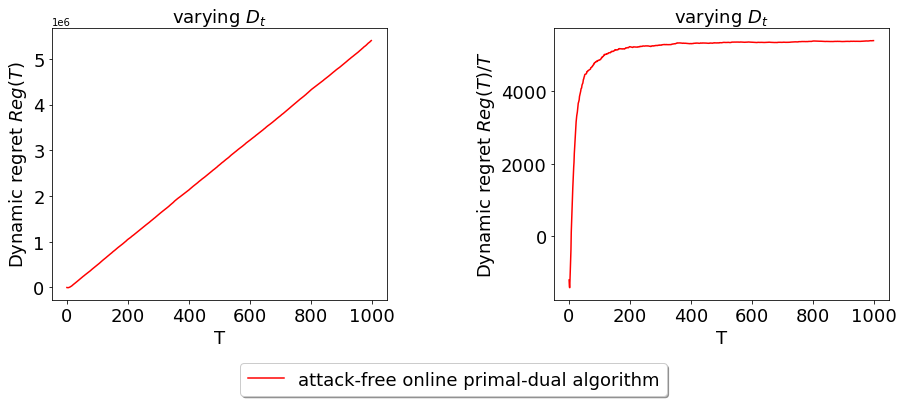

In [15]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret_T,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))

#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.png',format='png', bbox_inches='tight')

In [16]:
#累计的约束违反

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [18]:
sum_thermal_wind_power_station_strategy=np.loadtxt("./data/01_small_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt")
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt")

In [19]:
accumulative_constraint_violation=[]
accumulative_constraint_violation_T=[]
for T in range(1, 1000):
    accumulative_constraint_violation_auxiliary_variable=0
    for t in range(0, T): 
        accumulative_constraint_violation_auxiliary_variable=accumulative_constraint_violation_auxiliary_variable+(1/5)*sum_thermal_wind_power_station_strategy[t+1]-d_power_demand[t+1]
    accumulative_constraint_violation.append(abs(accumulative_constraint_violation_auxiliary_variable))
    accumulative_constraint_violation_T.append(abs(accumulative_constraint_violation_auxiliary_variable)/T)

In [20]:
accumulative_constraint_violation_T

[44.659041904000006,
 46.115205765,
 43.87065123333333,
 39.452967039499995,
 33.384684623999995,
 26.718223016333326,
 20.61493155714285,
 13.799820922499991,
 8.349201158444437,
 4.932312008199995,
 1.032660204545448,
 3.8642845278333398,
 7.919930924461545,
 11.332487471142864,
 14.84769975853334,
 17.637553142000005,
 19.80215128152942,
 21.660877144555563,
 24.06529033547369,
 25.776479908800006,
 27.36071795142858,
 28.823896975090918,
 30.213467724869574,
 31.25815924883334,
 32.83992569408001,
 33.70856928123077,
 34.402782216370376,
 35.36069752185714,
 36.082493242827574,
 37.02679486726665,
 37.99577725825805,
 38.458201501437486,
 39.11381963806059,
 39.703538830176456,
 40.44825678217142,
 41.10303506105555,
 41.64173367778378,
 42.60126224915789,
 43.1852633771282,
 43.55682207245,
 44.033321104780484,
 44.23820956585714,
 44.56485613386046,
 45.027569086954536,
 45.44414850644444,
 45.87377449469565,
 46.165075071234035,
 46.551700957375,
 46.80049245440815,
 47.07819464

In [21]:
#绘图 accumulative_constraint_violation和accumulative_constraint_violation_T

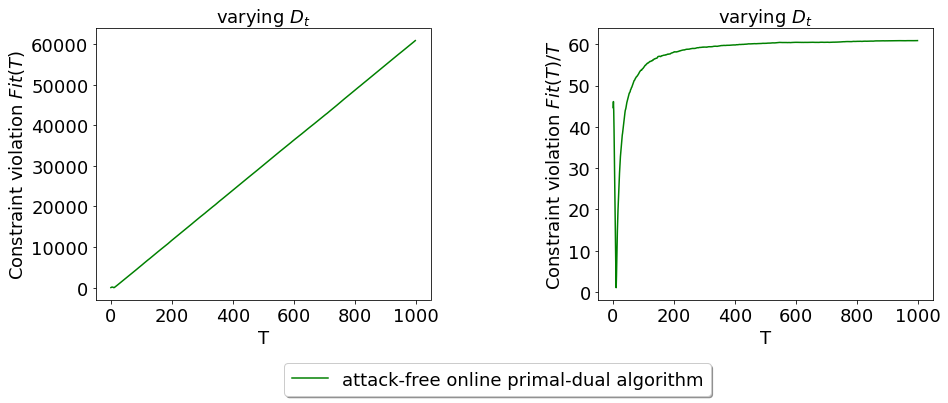

In [22]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation_T,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))


#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.png',format='png', bbox_inches='tight')